# 유방암의 임파선 전이 예측 AI 경진 대회
https://dacon.io/competitions/official/236011/talkboard/407176?page=1&dtype=recent
## 배경지식
+ 림프절은 암의 전이, 퍼지는데 치명적인 원인
+ 림프절 전이 여부에 따라 치료와 예후가 달라짐
+ 림프절 전이 여부와 전이 단계 파악이 핵심적인 역할
## 제공 데이터
+ 유방암 병리 슬라이드 영상
+ 임상 항목 데이터
## 주제
+ 유방암 병리 슬라이드 영상과 임상 항목을 조합하여 유방암의 임파선 전이 여부 이진 분류
## 데이터 이해
+ ID : 부여번호
+ img_path 
+ mask_path
+ 나이 : 진단시 나이
+ 수술연월일 : 연-월-일
+ 진단명 : 1-ductal, 2-lobular, 3-mucinous, 4-other
+ 암의 위치 : 1-right, 2-left, 3-both
+ 암의 개수 : 1-single, 2-multiple
+ NG : 핵의 모양 ,1-핵모양 정상, 2-중간, 3-이상
+ HG : 1-(scores of 3, 4, or 5): 조직학적 분화도가 좋아 전체적으로 합산 점수가 낮은 경우,
2-(scores of 6 or 7), 3-(scores of 8 or 9) : 조직학적 분화도가 나빠서 합산점수가 큰 경우  
4: Only microinvasion present (not graded)
+ HG_score_1 : 
+ HG_score_2
+ HG_score_3
+ DCIS or LCIS 여부 : 제자리암종(DCIS) 유무
+ DCIS or LCIS_type : 제자리암종내 괴사 유무
+ T_category
+ ER : 여성호르몬중 에스트로겐 수용체 발현 여부
+ ER_Allred_score
+ PR : 여성호르몬 중 프로게스테론 수용체 발현 여부
+ PR_Allred_score 
+ KI-67_LI_percent : 세포증식 수치
+ HER2 : 세포성장, 수용체 발현여부 표시 0- -, 1- +
+ HER2_IHC
+ HER2_SISH : 
+ HER2_SISH_ratio : 소수점 첫째자리 숫자 기입
+ N_category : 0-전이 X, 1-전이 O




In [1]:
import os 
import io
import zipfile
from zipfile import ZipFile
import pandas as pd
import requests
import tensorflow as tf
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import * 

C:\Users\User\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


### 데이터 로드 과정

In [ ]:
# with zipfile.ZipFile('/content/drive/MyDrive/Project/유방암/Data/open.zip', 'r') as existing_zip:
#     existing_zip.extractall('/content/drive/MyDrive/Project/유방암/Data/')

### 데이터 확인

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
data=pd.read_csv("data/train.csv")

In [3]:
data.head()

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,BC_01_0001,./train_imgs/BC_01_0001.png,-,63,2015-10-23,1,2,1,19.0,2.0,...,8.0,1.0,6.0,12.0,0.0,1.0,NaN,NaN,NaN,0
1,BC_01_0002,./train_imgs/BC_01_0002.png,-,51,2015-10-28,1,1,1,22.0,3.0,...,NaN,0.0,NaN,70.0,0.0,0.0,NaN,NaN,NaN,1
2,BC_01_0003,./train_imgs/BC_01_0003.png,-,37,2015-10-29,1,2,1,NaN,2.0,...,7.0,1.0,4.0,7.0,0.0,1.0,NaN,NaN,0.0,0
3,BC_01_0004,./train_imgs/BC_01_0004.png,-,54,2016-03-08,1,2,1,0.0,3.0,...,NaN,0.0,NaN,1.0,1.0,3.0,NaN,NaN,NaN,0
4,BC_01_0005,./train_imgs/BC_01_0005.png,-,57,2015-10-30,1,2,1,8.0,2.0,...,8.0,0.0,NaN,8.0,1.0,2.0,1.0,5.44,NaN,0


In [4]:
data.isna().sum()

ID                     0
img_path               0
mask_path              0
나이                     0
수술연월일                  0
진단명                    0
암의 위치                  0
암의 개수                  0
암의 장경                 69
NG                    51
HG                    86
HG_score_1            92
HG_score_2            92
HG_score_3            89
DCIS_or_LCIS_여부        0
DCIS_or_LCIS_type    874
T_category             4
ER                     1
ER_Allred_score      297
PR                     1
PR_Allred_score      453
KI-67_LI_percent     235
HER2                  14
HER2_IHC              24
HER2_SISH            753
HER2_SISH_ratio      825
BRCA_mutation        945
N_category             0
dtype: int64

### 결측치 처리 부분

In [211]:
data["암의 장경"].fillna(data["암의 장경"].mean(),inplace=True)

In [212]:
data.NG.fillna(0,inplace=True)

In [213]:
data["수술연월일"]=pd.to_datetime(data["수술연월일"])
data["년"]=0
data["월"]=0
data["일"]=0
for i in range(len(data)):
  data["년"][i]=data["수술연월일"][i].year
  data["월"][i]=data["수술연월일"][i].month
  data["일"][i]=data["수술연월일"][i].day

<ipython-input-213-0c0b2eae0a05>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["년"][i]=data["수술연월일"][i].year
<ipython-input-213-0c0b2eae0a05>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["월"][i]=data["수술연월일"][i].month
<ipython-input-213-0c0b2eae0a05>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["일"][i]=data["수술연월일"][i].day


In [214]:
data.drop(["DCIS_or_LCIS_type","BRCA_mutation","HER2_SISH_ratio","HER2_SISH","ER_Allred_score","PR_Allred_score","mask_path","img_path","수술연월일"],axis=1,inplace=True)

In [215]:
data["KI-67_LI_percent"].fillna(data["KI-67_LI_percent"].mean(),inplace=True)

In [29]:
#data=data.dropna()

In [216]:
for i in range(len(data)):
  data["ID"][i]=int(data["ID"][i].split("_")[2])

<ipython-input-216-0dc34220dde3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["ID"][i]=int(data["ID"][i].split("_")[2])


In [217]:
data.fillna(0,inplace=True)

In [218]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                1000 non-null   int64  
 1   나이                1000 non-null   int64  
 2   진단명               1000 non-null   int64  
 3   암의 위치             1000 non-null   int64  
 4   암의 개수             1000 non-null   int64  
 5   암의 장경             1000 non-null   float64
 6   NG                1000 non-null   float64
 7   HG                1000 non-null   float64
 8   HG_score_1        1000 non-null   float64
 9   HG_score_2        1000 non-null   float64
 10  HG_score_3        1000 non-null   float64
 11  DCIS_or_LCIS_여부   1000 non-null   int64  
 12  T_category        1000 non-null   float64
 13  ER                1000 non-null   float64
 14  PR                1000 non-null   float64
 15  KI-67_LI_percent  1000 non-null   float64
 16  HER2              1000 non-null   float64
 

In [219]:
X=data.drop("N_category",axis=1)
y=data.loc[:,"N_category"]

In [114]:
#X=pd.get_dummies(X,drop_first=True)

In [220]:
X

,ID,나이,진단명,암의 위치,암의 개수,암의 장경,NG,HG,HG_score_1,HG_score_2,...,DCIS_or_LCIS_여부,T_category,ER,PR,KI-67_LI_percent,HER2,HER2_IHC,년,월,일
0,1,63,1,2,1,19.000000,2.0,1.0,2.0,2.0,...,2,1.0,1.0,1.0,12.000000,0.0,1.0,2015,10,23
1,2,51,1,1,1,22.000000,3.0,3.0,3.0,3.0,...,0,2.0,0.0,0.0,70.000000,0.0,0.0,2015,10,28
2,3,37,1,2,1,18.375564,2.0,0.0,0.0,0.0,...,1,0.0,1.0,1.0,7.000000,0.0,1.0,2015,10,29
3,4,54,1,2,1,0.000000,3.0,3.0,3.0,3.0,...,1,0.0,0.0,0.0,1.000000,1.0,3.0,2016,3,8
4,5,57,1,2,1,8.000000,2.0,2.0,3.0,2.0,...,2,1.0,1.0,0.0,8.000000,1.0,2.0,2015,10,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3464,65,1,2,1,25.000000,1.0,1.0,2.0,1.0,...,0,2.0,1.0,0.0,18.037229,0.0,0.0,2006,12,22
996,3482,48,1,1,1,7.000000,1.0,1.0,1.0,1.0,...,0,1.0,1.0,1.0,18.037229,0.0,0.0,2006,11,17
997,3485,64,1,2,1,15.000000,1.0,1.0,2.0,1.0,...,0,1.0,1.0,1.0,18.037229,0.0,0.0,2006,11,10
998,3502,50,1,1,1,7.000000,1.0,1.0,1.0,2.0,...,0,1.0,0.0,0.0,18.037229,0.0,0.0,2006,9,22


In [221]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                1000 non-null   int64  
 1   나이                1000 non-null   int64  
 2   진단명               1000 non-null   int64  
 3   암의 위치             1000 non-null   int64  
 4   암의 개수             1000 non-null   int64  
 5   암의 장경             1000 non-null   float64
 6   NG                1000 non-null   float64
 7   HG                1000 non-null   float64
 8   HG_score_1        1000 non-null   float64
 9   HG_score_2        1000 non-null   float64
 10  HG_score_3        1000 non-null   float64
 11  DCIS_or_LCIS_여부   1000 non-null   int64  
 12  T_category        1000 non-null   float64
 13  ER                1000 non-null   float64
 14  PR                1000 non-null   float64
 15  KI-67_LI_percent  1000 non-null   float64
 16  HER2              1000 non-null   float64
 

In [156]:
import datetime

In [222]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=.3, random_state =2022)

In [223]:
# 모델 선언
model = XGBClassifier(n_estimators = 5,max_depth=3)

In [224]:
model.fit(x_train,y_train)

XGBClassifier(n_estimators=5)

In [225]:
pred = model.predict(x_val)

In [226]:
# 평가
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.82      0.94      0.87       154
           1       0.92      0.78      0.84       146

    accuracy                           0.86       300
   macro avg       0.87      0.86      0.86       300
weighted avg       0.87      0.86      0.86       300



In [90]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [309]:
parmas={'max_depth':[2,3,4,5,6],'n_estimators':[70,75,80,85,90],'learning_rate':[0.05,0.1,0.2]}

In [310]:
model=XGBClassifier()
model_gs=GridSearchCV(model,parmas)
model_gs.fit(x_train,y_train)

GridSearchCV(estimator=XGBClassifier(),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [2, 3, 4, 5, 6],
                         'n_estimators': [70, 75, 80, 85, 90]})

In [311]:
pred=model_gs.predict(x_val)
print(classification_report(y_val,pred))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       154
           1       0.90      0.79      0.84       146

    accuracy                           0.86       300
   macro avg       0.86      0.86      0.86       300
weighted avg       0.86      0.86      0.86       300



In [312]:
model_gs.best_params_

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 75}

In [327]:
test=pd.read_csv("/content/drive/MyDrive/Project/유방암/Data/test.csv")

In [314]:
test["암의 장경"].fillna(test["암의 장경"].mean(),inplace=True)

In [315]:
test.NG.fillna(0,inplace=True)

In [316]:
test["수술연월일"]=pd.to_datetime(test["수술연월일"])
test["년"]=0
test["월"]=0
test["일"]=0
for i in range(len(test)):
  test["년"][i]=test["수술연월일"][i].year
  test["월"][i]=test["수술연월일"][i].month
  test["일"][i]=test["수술연월일"][i].day

<ipython-input-316-9e79fc77bb26>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["년"][i]=test["수술연월일"][i].year
<ipython-input-316-9e79fc77bb26>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["월"][i]=test["수술연월일"][i].month
<ipython-input-316-9e79fc77bb26>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["일"][i]=test["수술연월일"][i].day


In [317]:
test.drop(["DCIS_or_LCIS_type","BRCA_mutation","HER2_SISH_ratio","HER2_SISH","ER_Allred_score","PR_Allred_score","img_path","수술연월일"],axis=1,inplace=True)

In [318]:
test["KI-67_LI_percent"].fillna(test["KI-67_LI_percent"].mean(),inplace=True)

In [319]:
test.fillna(0,inplace=True)

In [320]:
for i in range(len(test)):
  test["ID"][i]=int(test["ID"][i].split("_")[2])

<ipython-input-320-c55d1f92de9a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["ID"][i]=int(test["ID"][i].split("_")[2])


In [322]:
test=test.fillna(0)

In [239]:
#test=pd.get_dummies(test)

In [323]:
result=model_gs.predict(test)

In [324]:
result=pd.DataFrame(result)

In [325]:
result["ID"]=0

In [326]:
test["ID"]

0        11
1       220
2       233
3       258
4       260
       ... 
245    3328
246    3404
247    3418
248    3438
249    3446
Name: ID, Length: 250, dtype: int64

In [328]:
result["ID"]=test["ID"]

In [329]:
result=result[["ID",0]]

In [330]:
result=result.rename(columns={0:"N_category"})

In [331]:
result

,ID,N_category
0,BC_01_0011,1
1,BC_01_0220,0
2,BC_01_0233,0
3,BC_01_0258,0
4,BC_01_0260,1
...,...,...
245,BC_01_3328,1
246,BC_01_3404,1
247,BC_01_3418,0
248,BC_01_3438,0


In [332]:
result.to_csv("result.csv",index=False)

In [4]:
import cv2
import matplotlib.pyplot as plt

In [5]:
from PIL import Image
import numpy as np

In [6]:
image=cv2.imread("data"+data.img_path[1].split(".")[1]+".png",cv2.IMREAD_GRAYSCALE)

In [7]:
image=image[:3000,:3000]

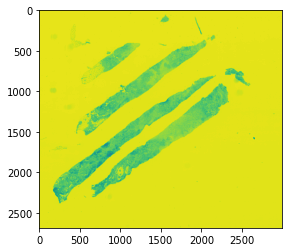

In [8]:
plt.imshow(image)

In [17]:
image_df=image_df.append(pd.DataFrame(image.flatten()).transpose())

In [20]:
image_df=pd.DataFrame(image.flatten()).transpose()

In [21]:
image_df

,0,1,2,3,4,5,6,7,8,9,...,6950990,6950991,6950992,6950993,6950994,6950995,6950996,6950997,6950998,6950999
0,244,244,244,244,244,244,244,244,244,244,...,241,241,241,241,241,241,241,241,242,243


In [ ]:
for i in range(1,len(data)):
    image=cv2.imread("data"+data.img_path[i].split(".")[1]+".png",cv2.IMREAD_GRAYSCALE)
    image=image[:3000,:3000]
    image_df=image_df.append(pd.DataFrame(image.flatten()).transpose())

In [ ]:
image_df